## Modified Model, with Attention

## Importing Dependencies

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import collections, random, re
from collections import Counter
from PIL import Image
import glob
from sklearn.model_selection import train_test_split
from skimage import io
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import sentence_bleu
import tensorflow as tf
from tensorflow.python.keras import Model
from tqdm import tqdm
import os
import nltk
import pickle
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print(tf. __version__)

2.11.0


In [4]:
images='/kaggle/input/flickr8k/Flickr8k_Dataset/Flicker8k_Images'
all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


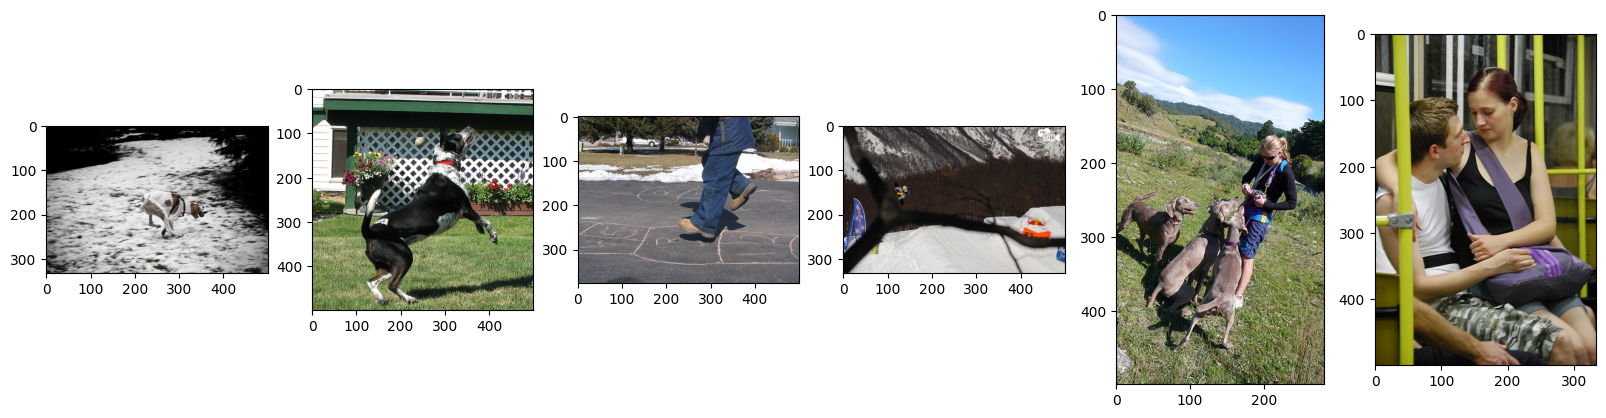

In [6]:
figure, axes = plt.subplots(1,6)
figure.set_figwidth(20)

for ax,image in zip(axes, all_imgs[0:6]):
    ax.imshow(io.imread(image), cmap=None)

## Caption Pre-Processing

In [7]:
text_file = '/kaggle/input/flickr8k/Flickr8k_Dataset/Flickr8k_text/Flickr8k.token.txt'

def load_doc(filename):
    with open(filename, 'r') as ff:
        next(ff) # to skip the header
        text = ff.read()
    return text

doc = load_doc(text_file)
print(doc[:300])

1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a woode


In [8]:
path_of_images='/kaggle/input/flickr8k/Flickr8k_Dataset/Flicker8k_Images/'
list_of_images_and_captions = []
for i in doc.split('\n'):
    image_id = i.split("\t",maxsplit=1)[0].split("#")[0]
    if (len(i.split("#", maxsplit=1)) != 2):
        print(i)
    if os.path.exists(path_of_images + "/" + str(image_id)):
        list_of_images_and_captions.append(i.split("#",maxsplit=1))

Removing the NULL entry

In [9]:
print(len(list_of_images_and_captions))
new_list = []
for i in list_of_images_and_captions:
    if len(i) != 2:
        print(i)
    else:
        new_list.append([i[0], str(i[1].split('\t')[1])])
print(len(new_list))
list_of_images_and_captions = new_list

40455
['']
40454


In [10]:
all_img_id= [img[0] for img in list_of_images_and_captions if img[0]] #store all the image id here
all_img_vector= [path_of_images+img[0] for img in list_of_images_and_captions if img[0]] #store all the image path here
annotations= [img[1] for img in list_of_images_and_captions if img[0]] #store all the captions here
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df.head()

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Flickr8k_Dataset/Flicke...,A girl going into a wooden building .
1,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Flickr8k_Dataset/Flicke...,A little girl climbing into a wooden playhouse .
2,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Flickr8k_Dataset/Flicke...,A little girl climbing the stairs to her playh...
3,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Flickr8k_Dataset/Flicke...,A little girl in a pink dress going into a woo...
4,1001773457_577c3a7d70.jpg,/kaggle/input/flickr8k/Flickr8k_Dataset/Flicke...,A black dog and a spotted dog are fighting


In [12]:
image_to_captions_dictionary = {}
for i in range(0, len(df)):
    if image_to_captions_dictionary.get(df['ID'][i]) == None:
        image_to_captions_dictionary[df['ID'][i]] = df['Captions'][i]
    else:
        image_to_captions_dictionary[df['ID'][i]] += (" " + df['Captions'][i])

In [14]:
annotations= ['<start> '+ annoted_caption + ' <end>' for annoted_caption in df.Captions] 
annotations_new = ['<start> '+ annoted_caption[1] + ' <end>' for annoted_caption in image_to_captions_dictionary.items()]
all_img_path= df.Path.unique().tolist() 

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40454
Total images present in the dataset: 8091


In [15]:
vocabulary= [] 
for cap in df.Captions.values:
  list_of_words = list(filter(lambda w: len(w)>0, re.split('\W+',cap.lower()))) 
  for word in list_of_words:
    vocabulary.append(word)

val_count=Counter(vocabulary)

In [16]:
def show_count(axs, space=.01):
    def _single(ax):
      for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
        value = '{:.1f}'.format(p.get_height())
        ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [18]:
max_words = 5000

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=max_words,
    filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token="<unk>")

tokenizer.fit_on_texts(annotations) 
train_seq = tokenizer.texts_to_sequences(annotations)

In [19]:
tokenizer.word_index['<pad>'] = 0 
tokenizer.index_word[0] = '<pad>' 

word_to_index_mapping = tokenizer.word_index
index_to_word_mapping = tokenizer.index_word

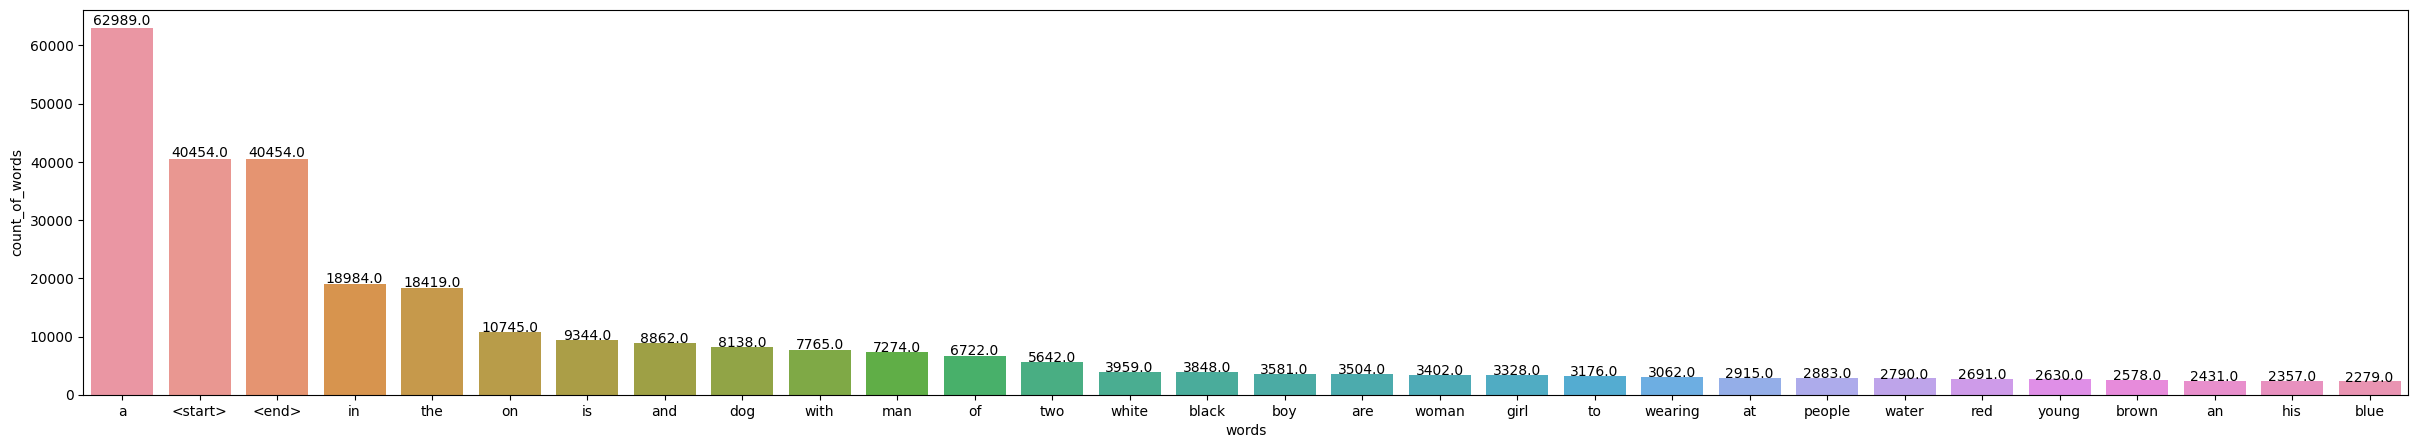

In [21]:
tokenizer_wc = Counter(tokenizer.word_counts)
top30_tokenizer_wc_df = pd.DataFrame(tokenizer_wc.most_common(30), columns=['words', 'count_of_words'])
plt.figure(figsize=(30,5))
top30_plot = sns.barplot(x='words', y='count_of_words', data=top30_tokenizer_wc_df)
show_count(top30_plot) 

In [22]:
max_seq_len = max([len(x) for x in train_seq]) 
cap_vector= tf.keras.preprocessing.sequence.pad_sequences(
    train_seq,
    maxlen=max_seq_len,
    dtype='int32',
    padding='post',
    truncating='post',
    value=0
)
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40454, 39)


In [23]:
print(cap_vector[0])
print(annotations[0])

cur_ptr = 0
image_to_cap_vector_dicitionary = {}
for key, value in image_to_captions_dictionary.items():
    image_to_cap_vector_dicitionary[key] = cap_vector[cur_ptr]
    cur_ptr += 1
print(len(image_to_cap_vector_dicitionary)) 

print(len(cap_vector))

[  3   2  20 317  65   2 197 118   4   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
<start> A girl going into a wooden building . <end>
8091
40454


## Image Pre-Processing

In [24]:
image_dataset = tf.data.Dataset.from_tensor_slices(all_img_path)

In [25]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    decoded_image = tf.io.decode_jpeg(image, channels=3)
    resized_image = tf.image.resize(decoded_image, (299, 299)) 
    preprocessed_image = tf.keras.applications.inception_v3.preprocess_input(resized_image) 
    return preprocessed_image, image_path

In [26]:
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
image_dataset = image_dataset.batch(64,drop_remainder=False)


In [27]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87910968/87910968 [==============================] - 0s 0us/step


Storing the Embeddings in a pickle file

In [28]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# this code here will store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model
# image_dict_features={}
# for img, img_path in tqdm(image_dataset): # for displaying progress
#     img_features = image_features_extract_model(img) # extracting features from images
#     # print(img_features.shape)
#     img_features_flattened = tf.reshape(img_features,(img_features.shape[0], -1, img_features.shape[3])) #flattening the image to reduce space occupancy
                                   
#     for batch_feature, path in zip(img_features_flattened, img_path):
#         path_feat = path.numpy().decode("utf-8")
#         image_dict_features[path_feat] =  batch_feature.numpy()

In [29]:
# import pickle
# with open('embeddings.pkl', 'wb') as files:
#     pickle.dump(image_dict_features, files)

In [30]:
# import os
# os.chdir(r'kaggle/working')
# !zip -r embeddings.zip '/kaggle/working/embeddings.pkl'

In [31]:
image_dict_features={}
with open('/kaggle/input/vision-embeddings/kaggle/working/embeddings.pkl', 'rb') as files:
    image_dict_features = pickle.load(files)

In [32]:
print(len(image_dict_features))

8091


In [33]:
all_img_path= df.Path.tolist()

Generating the train, test, validation splits for captions andimages

In [34]:
train_file = '/kaggle/input/flickr8k/Flickr8k_Dataset/Flickr8k_text/Flickr_8k.trainImages.txt'
with open(train_file, 'r') as f:
    train_file_names = f.read().splitlines()
test_file = '/kaggle/input/flickr8k/Flickr8k_Dataset/Flickr8k_text/Flickr_8k.testImages.txt'
with open(test_file, 'r') as f:
    test_file_names = f.read().splitlines()
val_file = '/kaggle/input/flickr8k/Flickr8k_Dataset/Flickr8k_text/Flickr_8k.valImages.txt'
with open(val_file, 'r') as f:
    val_file_names = f.read().splitlines()
path_train = ['/kaggle/input/flickr8k/Flickr8k_Dataset/Flicker8k_Images/' + str(img_path) for img_path in train_file_names]
cap_train = [image_to_cap_vector_dicitionary[img_path] for img_path in train_file_names]
path_test = ['/kaggle/input/flickr8k/Flickr8k_Dataset/Flicker8k_Images/' + str(img_path) for img_path in test_file_names]
cap_test = [image_to_cap_vector_dicitionary[img_path] for img_path in test_file_names]
path_val = ['/kaggle/input/flickr8k/Flickr8k_Dataset/Flicker8k_Images/' + str(img_path) for img_path in val_file_names]
cap_val = [image_to_cap_vector_dicitionary[img_path] for img_path in val_file_names]
print(len(cap_train))
print(len(path_train))
print(len(cap_val))
print(len(path_val))
print(len(cap_test))
print(len(path_test))

6000
6000
1000
1000
1000
1000


In [35]:
path_train_new = []
cap_train_new = []
for i in range(len(df)):
    if df['Path'][i] in path_train:
        path_train_new.append(df['Path'][i])
        cap_train_new.append(cap_vector[i])
    
path_test_new = []
cap_test_new = []
for i in range(len(df)):
    if df['Path'][i] in path_test:
        path_test_new.append(df['Path'][i])
        cap_test_new.append(cap_vector[i])

path_val_new = []
cap_val_new = []
for i in range(len(df)):
    if df['Path'][i] in path_val:
        path_val_new.append(df['Path'][i])
        cap_val_new.append(cap_vector[i])

path_train = path_train_new
cap_train = cap_train_new
path_test = path_test_new
cap_test= cap_test_new
path_val = path_val_new
cap_val = cap_val_new
print(len(path_train))
print(len(cap_train))
print(len(path_test))
print(len(cap_test))
print(len(path_val))
print(len(cap_val))

29999
29999
5000
5000
5000
5000


In [36]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 29999
Testing data for images: 5000
Training data for Captions: 29999
Testing data for Captions: 5000


## Model Definition

In [37]:
def map_func(img,cap):
	img_tensor = image_dict_features[img.decode('utf-8')]
	return img_tensor, cap

In [38]:
def gen_dataset(img, cap, batch=64, buffer=1000):
	dataset_from_tensor = tf.data.Dataset.from_tensor_slices((img,cap))
	dataset_from_tensor = dataset_from_tensor.map(lambda x, y: tf.numpy_function(map_func, [x, y], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
	dataset_from_tensor = dataset_from_tensor.shuffle(buffer)
	dataset_from_tensor = dataset_from_tensor.batch(batch, drop_remainder=False)
	dataset_from_tensor = dataset_from_tensor.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
		
	return dataset_from_tensor


In [39]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [41]:
embedding_dim = 256 
units = 512
vocab_size = 5001 
train_num_steps = len(path_train) // 64 
test_num_steps = len(path_test) // 64 
attention_features_shape = 64

In [42]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim,activation='relu') 
        
        
    def call(self, features):
        features = self.dense(features) 
        return features

In [43]:
encoder=Encoder(embedding_dim) 

In [44]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) 
        self.W2 = tf.keras.layers.Dense(units) 
        self.V = tf.keras.layers.Dense(1) 
        self.units=units

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1) 
        score = tf.keras.activations.tanh(self.W1(features)+self.W2(hidden_with_time_axis))
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1)
        context_vector = attention_weights*features 
        context_vector = tf.reduce_sum(context_vector, axis = 1)
        
        return context_vector, attention_weights

In [45]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) 
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero=False) 
        self.lstm = tf.keras.layers.LSTM(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform') 
        self.d1 = tf.keras.layers.Dense(self.units) 
        self.d2 = tf.keras.layers.Dense(vocab_size) 
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features,hidden) 
        embed = self.embed(x)
        embed = tf.concat([tf.expand_dims(context_vector,1), embed], axis=-1) 
        output,state = self.lstm(embed) 
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) 
        output = self.d2(output) 
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [46]:
decoder=Decoder(embedding_dim, units, vocab_size)

## Training

In [48]:
optimizer = tf.keras.optimizers.Adam() 
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

In [49]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0)) 
    loss_ = loss_object(real, pred) 

    mask = tf.cast(mask, dtype=loss_.dtype) 
    loss_ *= mask 

    return tf.reduce_mean(loss_)

In [50]:
checkpoint_path = "./checkpoint/" 
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5) 

In [51]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [52]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        encoded_data = encoder(img_tensor)
        for x in range(1,target.shape[1]):
            pred, hidden, _ = decoder(dec_input, encoded_data, hidden)
            loss += loss_function(target[:, x], pred)
            dec_input = tf.expand_dims(target[:,x], 1)
    avg_loss = (loss/int(target.shape[1])) 
    all_trainable_vars = encoder.trainable_variables + decoder.trainable_variables 
    gradients = tape.gradient(loss,all_trainable_vars)
    optimizer.apply_gradients(zip(gradients, all_trainable_vars))
        
    return loss, avg_loss

In [53]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        encoder_output = encoder(img_tensor)
        for x in range(1,target.shape[1]):
            pred, hidden, _ = decoder(dec_input, encoder_output, hidden)
            loss += loss_function(target[:,x], pred)
            predicted_id = tf.argmax(pred,1)
            dec_input = tf.expand_dims(predicted_id, 1)

        avg_loss = (loss/int(target.shape[1]))

        
    return loss, avg_loss

In [54]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss = total_loss / train_num_steps
    return avg_test_loss

In [55]:
loss_plot = []
test_loss_plot = []
EPOCHS = 10

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/10 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.281, & test loss is 0.178
Time taken for 1 epoch 206.50519943237305 sec

Test loss has been reduced from 100.000 to 0.178


 10%|█         | 1/10 [03:26<31:00, 206.76s/it]

For epoch: 2, the train loss is 0.980, & test loss is 0.157
Time taken for 1 epoch 75.04298210144043 sec

Test loss has been reduced from 0.178 to 0.157


 30%|███       | 3/10 [05:59<12:18, 105.49s/it]

For epoch: 3, the train loss is 0.892, & test loss is 0.145
Time taken for 1 epoch 76.83865976333618 sec

Test loss has been reduced from 0.157 to 0.145


 40%|████      | 4/10 [07:15<09:24, 94.10s/it] 

For epoch: 4, the train loss is 0.832, & test loss is 0.136
Time taken for 1 epoch 76.4458909034729 sec

Test loss has been reduced from 0.145 to 0.136


 50%|█████     | 5/10 [08:31<07:17, 87.51s/it]

For epoch: 5, the train loss is 0.782, & test loss is 0.128
Time taken for 1 epoch 75.66231417655945 sec

Test loss has been reduced from 0.136 to 0.128


 60%|██████    | 6/10 [09:44<05:30, 82.69s/it]

For epoch: 6, the train loss is 0.738, & test loss is 0.121
Time taken for 1 epoch 73.1536614894867 sec

Test loss has been reduced from 0.128 to 0.121


 70%|███████   | 7/10 [11:01<04:01, 80.63s/it]

For epoch: 7, the train loss is 0.699, & test loss is 0.115
Time taken for 1 epoch 76.21520113945007 sec

Test loss has been reduced from 0.121 to 0.115


 80%|████████  | 8/10 [12:14<02:36, 78.36s/it]

For epoch: 8, the train loss is 0.662, & test loss is 0.109
Time taken for 1 epoch 73.3252809047699 sec

Test loss has been reduced from 0.115 to 0.109


 90%|█████████ | 9/10 [13:30<01:17, 77.47s/it]

For epoch: 9, the train loss is 0.628, & test loss is 0.104
Time taken for 1 epoch 75.32701063156128 sec

Test loss has been reduced from 0.109 to 0.104


100%|██████████| 10/10 [14:42<00:00, 88.28s/it]

For epoch: 10, the train loss is 0.597, & test loss is 0.098
Time taken for 1 epoch 72.41733646392822 sec

Test loss has been reduced from 0.104 to 0.098


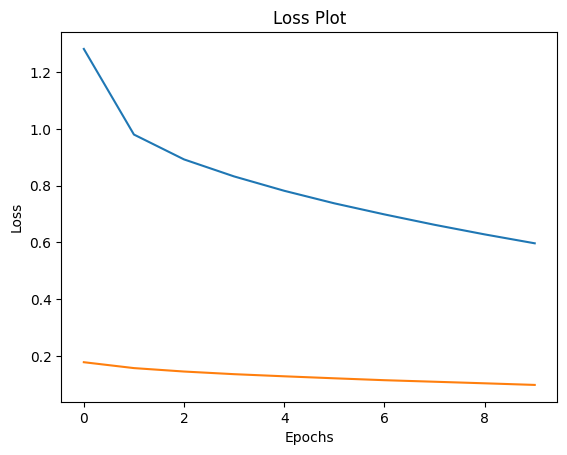

In [56]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Evaluation of model, including  BLEU and METEOR metrics

In [57]:
def evaluate(image):
    attention_plot = np.zeros((max_seq_len, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) 
    img_tensor_val = image_features_extract_model(temp_input) 
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) 

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_seq_len):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) 

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy() 
        
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot, predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions


In [58]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [59]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpor

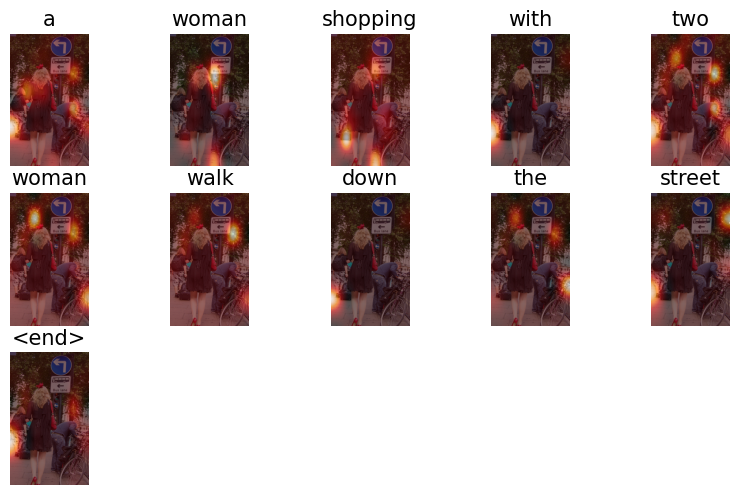

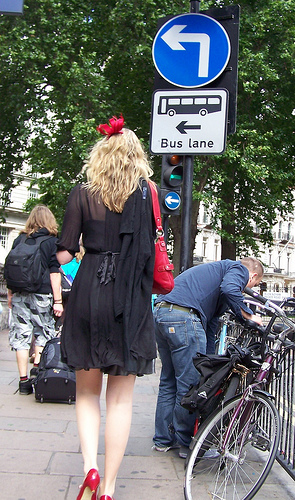

In [63]:
!pip install -U nltk
# !pip install nltk==3.5
import nltk
!python3 -m nltk.downloader wordnet
# nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from nltk.translate.meteor_score import meteor_score
# nltk.download()
# import evaluate
# meteor = evaluate.load('meteor')
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
meteor_score_returned = meteor_score(reference, hypothesis=candidate)
print(f"BELU score: {score*100}")
print("METEOR score: ", meteor_score_returned*100)

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [64]:
avg_bleu = 0
avg_meteor = 0
num_test_cases = len(path_test)
for i in tqdm(range(len(path_test))):
    test_image = path_test[i]

    real_caption = ' '.join([tokenizer.index_word[k] for k in cap_test[i] if k not in [0]])
    result, attention_plot, pred_test = evaluate(test_image)


    real_caption=filt_text(real_caption)      


    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    avg_bleu += score
    avg_meteor += meteor_score(reference, candidate)

  0%|          | 3/5000 [00:01<34:18,  2.43it/s]/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  """
100%|██████████| 5000/5000 [29:43<00:00,  2.80it/s]


In [65]:
avg_bleu = avg_bleu / num_test_cases
print("Average BLEU score:", avg_bleu * 100)
avg_meteor = avg_meteor / num_test_cases
print("Average METEOR score:", avg_meteor*100)

Average BLEU score: 25.41718546822364
Average METEOR score: 25.67805187846878
